In [48]:
# flatten 2d masks (lat, lon) mask files to 1d (record)

In [49]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs      # map projections
import re
import regionmask

In [50]:
# 1, create a mask
input_file = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-03/OutputDir/GEOSChem.SpeciesConc.20180128_0000z.nc4'
ds_input   = xr.open_dataset(input_file)
dr  = ds_input['SpeciesConc_CO2'].isel(lev=0)

In [51]:
mask = regionmask.defined_regions.giorgi.mask(dr)

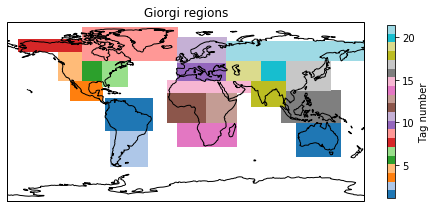

In [52]:
# plot the mask
fig = plt.figure(figsize=[8, 4])

proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='tab20', vmax = 21.5, cbar_kwargs={'shrink': 0.8, 'label': 'Tag number'})
ax.set_title("Giorgi regions")
ax.coastlines();

In [53]:
# 2, separate masks, store them in 2d arrays, flatten them to 1d array
# 2.1, create and initialise an empty dataarray
lat_res = 2    # horizontal resolution of lat and lon
lon_res = 2.5
lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
lon = np.linspace(-180, 177.5, int(360/lon_res))

var_2d = xr.DataArray(data = np.nan, 
                      dims = ('lat', 'lon'), 
                      coords = {'lat': lat,
                                'lon': lon},
                      name = 'tmp')
var_2d = var_2d.astype(dtype='float32')
#var_2d

var_1d = xr.DataArray(0, coords=[range(len(lat)*len(lon)*31)], dims=['record'], name = 'MASK1')
var_1d = var_1d.astype(dtype='float32')
ds_mask = var_1d.to_dataset() # initialise a dataset to store all dataarrays
ds_mask

<xarray.Dataset>
Dimensions:  (record: 406224)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
Data variables:
    MASK1    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [54]:
# 2.2, loop over mask file, for different masks
max_nm = mask.max().values
for iregion in range(1,int(max_nm)+1):
    var_2d[:,:] = 0.
    ind = mask == iregion
    var_2d.values[ind] = 1.
    flat = var_2d.to_dataframe()
    flat.reset_index(inplace=True)
    var_1d.values = np.tile(flat['tmp'],31)
    maskname = 'MASK' + str(iregion)
    ds_mask[maskname] = var_1d.copy()
    #print(type(flat['tmp'][3]))

In [55]:
# 2.3, one additional mask for ocean and low emitting regions
iregion = 22
var_2d[:,:] = 0.
mask_nan = np.isnan(mask)
var_2d = mask_nan.where(True)
flat = var_2d.to_dataframe()
flat.reset_index(inplace=True)
var_1d.values = np.tile(flat['region'],31)
maskname = 'MASK' + str(iregion)
ds_mask[maskname] = var_1d.copy()
ds_mask[maskname]
#target['MASK'][0,:,:] = mask_nan.where(True)

<xarray.DataArray 'MASK22' (record: 406224)>
array([1., 1., 1., ..., 1., 1., 1.])
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223

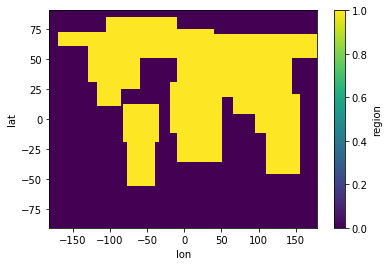

In [56]:
# 2.4, another mask for land
var_2d[:,:] = 0.
mask_nan = ~np.isnan(mask)
var_2d = mask_nan.where(True)
var_2d.plot()
flat = var_2d.to_dataframe()
flat.reset_index(inplace=True)
var_1d.values = np.tile(flat['region'],31)
ds_mask['land'] = var_1d.copy()

In [57]:
# 2.5, latitudinal masks
for region in ['high_lat', 'mid_lat', 'low_lat']:
    var_2d[:,:] = 1
#ds_mask['high_lat'] = var_2d.where(abs(var_2d.lat) >= 60, 0.0)
#ds_mask['low_lat']  = var_2d.where(abs(var_2d.lat) <= 30, 0.0)
#ds_mask['mid_lat']  = var_2d.where(abs(abs(var_2d.lat) - 45) <= 15, 0.0)
    if region == 'high_lat':
        var_2d = var_2d.where(abs(var_2d.lat) >= 60, 0.0)
    elif region == 'mid_lat':
        var_2d = var_2d.where(abs(abs(var_2d.lat) - 45) <= 15, 0.0)
    elif region == 'low_lat':
        var_2d = var_2d.where(abs(var_2d.lat) <= 30, 0.0)
    
    flat = var_2d.to_dataframe()
    #flat.reset_index(inplace=True)
    var_1d.values = np.tile(flat['region'],31)
    ds_mask[region] = var_1d.copy()

In [58]:
output_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
# Name of output netCDF file
output_file = output_directory + 'flatten_mask.nc'

In [59]:
ds_mask.attrs['comment'] = '1d mask file'
ds_mask.attrs

{'comment': '1d mask file'}

In [60]:
ds_mask = ds_mask.astype(dtype='float32').copy()

In [61]:
ds_mask

<xarray.Dataset>
Dimensions:   (record: 406224)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
Data variables:
    MASK1     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK2     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK3     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK4     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK5     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK6     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK7     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK8     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK9     (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK10    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK11    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK12    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK13    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK14    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK15    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK16    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK17    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK18    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK19    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK20    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK21    (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MASK22    (record) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    land      (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    high_lat  (record) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    mid_lat   (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    low_lat   (record) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [62]:
ds_mask.to_netcdf(path=output_file)